# Visualization of a MARIDA patch with its corresponding pre-processed L1C Copernicus Hub patch
The patches I took from Copernicus Hub are larger than the ones of MARIDA. This notebook visualizes the Copernicus Hub and MARIDA patches.

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

import os

In [22]:
def number_starting_with_zero_2_number(number_str: str) -> str:
    """Removes the first character of a string if it is a zero

    Args:
        number_str (str): string version of the number to consider

    Returns:
        str: string version of the number without the zero
    """
    if int(number_str[0]) == 0:
        number_str = number_str[-1]
    return number_str

In [23]:
marida_patches_path = "/data/anomaly-marine-detection/data/patches/"
cop_hub_patches_path = "/data/pyraws_luca/pyraws/generate_l1c/l1c_images"

number = "6"
ext = ".tif"
marida_patch_name = "S2_29-8-17_51RVQ" #"S2_29-11-15_16PEC"
L1C = "_l1c_" 

# MARIDA excluded bands B09 and B10 => bands to use to do keypoints matching:
# B01, B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12

bands_for_keypoint_matching = \
    ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
 
band_cop_hub = "B04" # "B04"

if band_cop_hub == "B09" or band_cop_hub == "B10":
    raise Exception("MARIDA removed bands B09 and B10")
elif band_cop_hub == "B11" or band_cop_hub == "B12":
    # we subtract 2 if it is band B11 or B12 due to the removal of previous bands B09 and B10
    band_marida = int(number_starting_with_zero_2_number(band_cop_hub[-2:])) - 2
elif band_cop_hub == "B8A":
    band_marida = 8
else:   
    band_marida = int(number_starting_with_zero_2_number(band_cop_hub[-2:])) - 1

In [24]:
def acquire_data(file_name):
    """Read an L1C Sentinel-2 image from a cropped TIF. The image is represented as TOA reflectance.
    Args:
        file_name (str): event ID.
    Raises:
        ValueError: impossible to find information on the database.
    Returns:
        np.array: array containing B8A, B11, B12 of a Seintel-2 L1C cropped tif.
        dictionary: dictionary containing lat and lon for every image point.
    """

    with rasterio.open(file_name) as raster:
        img_np = raster.read()
        sentinel_img = img_np.astype(np.float32)
        height = sentinel_img.shape[1]
        width = sentinel_img.shape[2]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(raster.transform, rows, cols)
        lons = np.array(ys)
        lats = np.array(xs)
        coords_dict = {"lat": lats, "lon": lons}

    sentinel_img = sentinel_img.transpose(
        1, 2, 0
    )  # / 10000 + 1e-13  # Diving for the default quantification value

    return sentinel_img, coords_dict

(256, 256, 11)


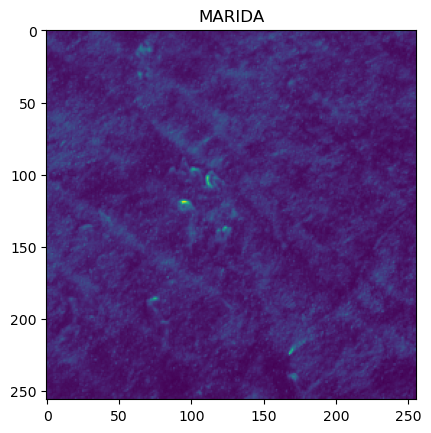

In [25]:
marida_path = os.path.join(marida_patches_path, marida_patch_name, marida_patch_name + "_" + number + ext)
img_marida, _ = acquire_data(marida_path)
print(img_marida.shape)
plt.title("MARIDA")
plt.imshow(img_marida[:, :, band_marida])

(296, 296, 1)


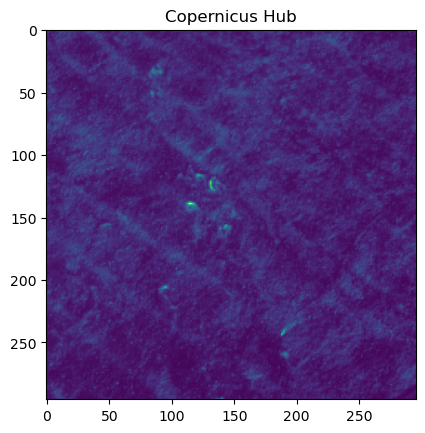

In [26]:
img_cop_hub, _ = acquire_data(
    os.path.join(
        cop_hub_patches_path, 
        marida_patch_name, 
        marida_patch_name + "_" + number,
        marida_patch_name + "_" + number + L1C + band_cop_hub + ext)
)
print(img_cop_hub.shape)
plt.title("Copernicus Hub")
plt.imshow(img_cop_hub)

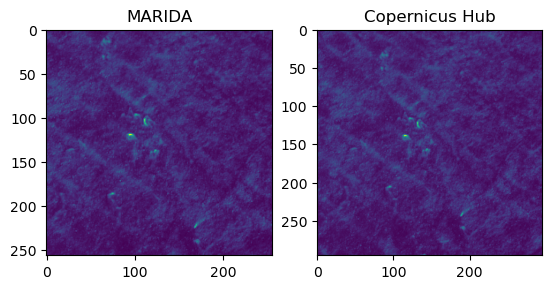

In [27]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title("MARIDA")
ax[0].imshow(img_marida[:, :, band_marida] / img_marida[:, :, band_marida].max())
ax[1].set_title("Copernicus Hub")
ax[1].imshow(img_cop_hub / img_cop_hub.max())

In [28]:
def scale_img_to_0_255(img: np.ndarray) -> np.ndarray:
    return ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')

In [29]:
import cv2 as cv
def save_img(img: np.ndarray, path: str):
    cv.imwrite(path, img)

In [30]:

img_marida = scale_img_to_0_255(img_marida[:, :, band_marida])
print(img_marida.shape)
save_img(img_marida, "/data/anomaly-marine-detection/data/l1c_copernicus_hub/images_before_keypoint_matching/img_marida.png")

img_cop_hub = scale_img_to_0_255(img_cop_hub[:, :, 0])
print(img_cop_hub.shape)
save_img(img_cop_hub, "/data/anomaly-marine-detection/data/l1c_copernicus_hub/images_before_keypoint_matching/img_cop_hub.png")

(256, 256)
(296, 296)
